<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>


Name: Alireza Sabounchi

STID: 401212454

In the following notebook, we use a ct-scan image to create its sinogram, then try to reconstruct the image by applying back projection on the obtained sinogram.

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=63cb9b25bc8437e90f0b348eb5f0bfd85090eec618404696046e186ad93a7080
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
import numpy as np
import imutils
from skimage.transform import rotate ## Image rotation routine
import scipy.fftpack as fft          ## Fast Fourier Transform
import scipy.misc
from PIL import Image
import matplotlib.pyplot as pyp

In [3]:
def inverse_fft_translate(operator):
    return fft.irfft(operator, axis=1)

In [4]:
# ref_image=Image.open('/content/CT-abdomen-400x267.jpg').convert('L')
ref_image=Image.open('/kaggle/input/ct-abdomen/CT-abdomen-400x267.jpg').convert('L')

In [5]:
def radon(image, steps):
    """
    Computes the Radon Transform of an image.

    Parameters:
    -----------
    image : ndarray
        Input 2D array representing the grayscale image to be transformed.

    steps : int
        Number of projections (angles) used to compute the transform.

    Returns:
    --------
    ndarray
        A sinogram representing the accumulated projections of the input image.
    """

    height, width = image.shape
    
    # The sinogram width = length of the image
    # The sinogram height = number of angles (steps)
    sinogram = np.zeros((steps, max(height, width))) # (r, theta(steps))
    theta = np.linspace(0., -180., steps)


    for i in range(steps):
        rotated = rotate(image, theta[i])
        
        # Sum of the pixel values along columns = projection
        projection = np.sum(rotated, axis=0)
        sinogram[i] = projection
    
    return sinogram

In [6]:
sinogram=radon(np.array(ref_image),600)

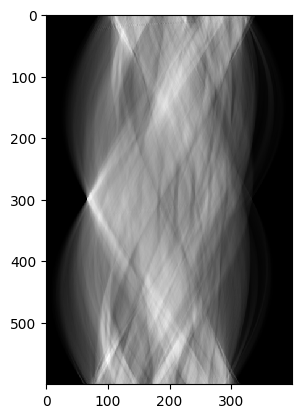

In [7]:
pyp.imshow(sinogram,interpolation='nearest',cmap='gray')

In [8]:
def back_project(operator):
    """
    Performs the back-projection operation to reconstruct an image
    from its projections (sinogram).

    This function takes a sinogram as input, where each row corresponds to a
    projection of the original image at a specific angle. It applies the inverse
    Radon Transform through back-projection by rotating each projection back to
    its original angle and accumulating them to form the final reconstructed image.

    Parameters:
    -----------
    operator : ndarray
        A 2D array representing the sinogram, where each row is a projection
        at a specific angle.

    Returns:
    --------
    ndarray
        The reconstructed image (laminogram) obtained through back-projection.
    """
    pass  # Placeholder for future implementation

    num_angles, projection_width = operator.shape
    theta = np.linspace(0., -180., num_angles)
    reconstructed = np.zeros((projection_width, projection_width))
    
    # Coordinates for the output, centered in the middle
    x = np.arange(projection_width) - projection_width / 2
    y = np.arange(projection_width) - projection_width / 2
    X, Y = np.meshgrid(x, y)

    for i in range(num_angles):
        angle_rad = np.deg2rad(theta[i])
        
        # Calculate the positions in the projection for each pixel (rad formula)
        t = X * np.cos(angle_rad) + Y * np.sin(angle_rad)
        
        # Map these positions to the closest indices in the projection
        proj_coords = np.clip(np.round(t + projection_width / 2).astype(int), 0, projection_width - 1)
        projection = operator[i]
        reconstructed += projection[proj_coords]
    reconstructed /= num_angles
    
    return reconstructed


In [9]:
unfiltered_reconstruction = back_project(sinogram)

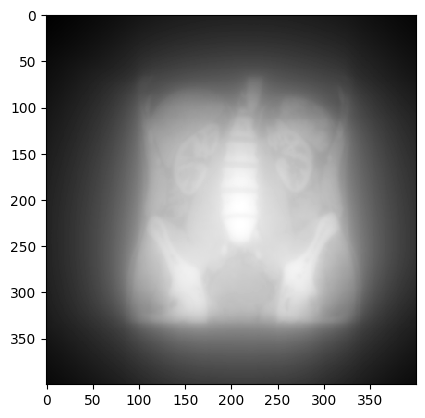

In [10]:
pyp.imshow(unfiltered_reconstruction,interpolation='nearest',cmap='gray')

In [11]:
def fft_translate(projs):
    #Build 1-d FFTs of an array of projections, each projection 1 row of the array.
    return fft.rfft(projs, axis=1)

In [12]:
frequency_domain_sinogram = fft_translate(sinogram)

In [13]:
def ramp_filter(ffts):
    """
    Applies a ramp filter to a 2D array of 1D FFTs along its rows.

    The ramp filter enhances the high-frequency components, which helps
    in the reconstruction of sharp edges in an image. This technique is
    often used in filtered back-projection algorithms to improve the
    quality of the reconstructed image.

    Parameters:
    -----------
    ffts : ndarray
        A 2D array where each row represents the 1D Fourier Transform (FFT)
        of a projection. Shape is (N, M)

    Returns:
    --------
    ndarray
        A 2D array of the same shape as the input, where each row has been
        multiplied by the corresponding ramp filter values.
    """
    num_angles, num_freqs = ffts.shape
    ramp = np.linspace(0, 1, num_freqs)

    # Apply the filter to each projection's FFT
    filtered_ffts = ffts * ramp[None, :]
    
    return filtered_ffts


In [14]:
filtered_frequency_domain_sinogram = ramp_filter(frequency_domain_sinogram)

In [15]:
filtered_spatial_domain_sinogram = inverse_fft_translate(filtered_frequency_domain_sinogram)

In [16]:
reconstructed_image = back_project(filtered_spatial_domain_sinogram)

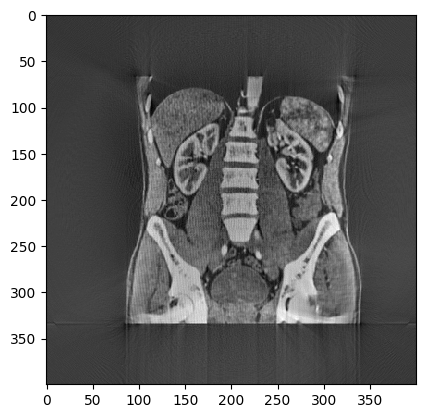

In [17]:
pyp.imshow(reconstructed_image,interpolation='nearest',cmap='gray')